# TensorFlow Regression Example

## Creating Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 1 Million Points
x_data = np.linspace(0.0,10.0,1000000)

In [3]:
noise = np.random.randn(len(x_data))

In [4]:
# y = mx + b + noise_levels
b = 5

y_true =  (0.5 * x_data ) - noise * np.linspace(-1,1,1000000) + 10

In [5]:
my_data = pd.concat([pd.DataFrame(data=x_data,columns=['X Data']),pd.DataFrame(data=y_true,columns=['Y'])],axis=1)

In [6]:
my_data.head()

,X Data,Y
0,0.00000,9.311077
1,0.00001,9.209635
2,0.00002,10.342279
3,0.00003,9.154111
4,0.00004,10.376435


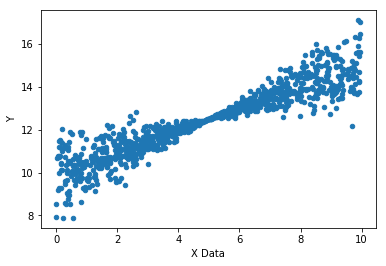

In [7]:
my_data.sample(n=1000).plot(kind='scatter',x='X Data',y='Y')

# TensorFlow
## Batch Size

We will take the data in batches (1,000,000 points is a lot to pass in at once)

In [8]:
import tensorflow as tf

In [9]:
# Random 10 points to grab
batch_size = 8

** Variables **

In [10]:
# np.random.rand is by default float64, needs to be float32 to 
# match spec on xph and yph below at float32
rval = np.random.rand(2).astype(np.float32)
m = tf.Variable(rval[0] )
b = tf.Variable(rval[1] )
print( (rval[0],rval[1]) )

(0.49171475, 0.12779891)


** Placeholders **

In [11]:
xph = tf.placeholder(tf.float32,[batch_size])
# y_true...
yph = tf.placeholder(tf.float32,[batch_size])

** Graph **

In [12]:
y_model = m*xph + b

** Loss Function **

In [13]:
error = tf.reduce_sum(tf.square(yph-y_model))

** Optimizer **

In [14]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(error)

** Initialize Variables **

In [15]:
init = tf.global_variables_initializer()

### Session

In [16]:
with tf.Session() as sess:
    sess.run(init)
    batches = 5000
    for i in range(batches):
        rand_ind = np.random.randint(len(x_data),size=batch_size)
        feed = {xph:x_data[rand_ind],yph:y_true[rand_ind]}
        sess.run(train,feed_dict=feed)
    model_m,model_b = sess.run([m,b])

In [17]:
model_m

0.52511764

In [18]:
model_b

10.000239

### Results

In [19]:
y_hat = x_data * model_m + model_b

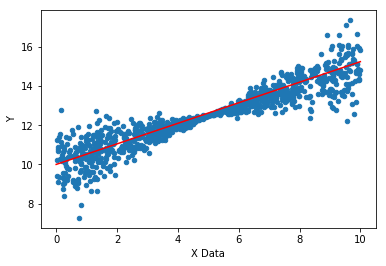

In [20]:
my_data.sample(n=1000).plot(kind='scatter',x='X Data',y='Y')
plt.plot(x_data,y_hat,'r')

## tf.estimator API

Much simpler API for basic tasks like regression! We'll talk about more abstractions like TF-Slim later on.

In [21]:
feat_cols = [tf.feature_column.numeric_column('x',shape=[1])]

In [22]:
estimator = tf.estimator.LinearRegressor(feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_session_config': None, '_tf_random_seed': 1, '_model_dir': '/var/folders/9y/n0rxh9rj60q4v8zgsclp0gm97tm33p/T/tmplyt790f4', '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None}


### Train Test Split

We haven't actually performed a train test split yet! So let's do that on our data now and perform a more realistic version of a Regression Task

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
x_train, x_eval, y_train, y_eval = train_test_split(x_data,y_true,test_size=0.3, random_state = 101)

In [25]:
print(x_train.shape)
print(y_train.shape)

print(x_eval.shape)
print(y_eval.shape)

(700000,)
(700000,)
(300000,)
(300000,)


### Set up Estimator Inputs

In [26]:
# Can also do .pandas_input_fn
input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=None,shuffle=True)

In [27]:
train_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=1000,shuffle=False)

In [28]:
eval_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_eval},y_eval,batch_size=4,num_epochs=1000,shuffle=False)

### Train the Estimator

In [29]:
estimator.train(input_fn=input_func,steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/9y/n0rxh9rj60q4v8zgsclp0gm97tm33p/T/tmplyt790f4/model.ckpt.
INFO:tensorflow:loss = 634.213, step = 1
INFO:tensorflow:global_step/sec: 1508.14
INFO:tensorflow:loss = 39.4259, step = 101 (0.067 sec)
INFO:tensorflow:global_step/sec: 1536.33
INFO:tensorflow:loss = 77.2712, step = 201 (0.065 sec)
INFO:tensorflow:global_step/sec: 1597.06
INFO:tensorflow:loss = 65.1354, step = 301 (0.063 sec)
INFO:tensorflow:global_step/sec: 1601.59
INFO:tensorflow:loss = 76.3873, step = 401 (0.062 sec)
INFO:tensorflow:global_step/sec: 1555.57
INFO:tensorflow:loss = 30.6647, step = 501 (0.064 sec)
INFO:tensorflow:global_step/sec: 1569.69
INFO:tensorflow:loss = 54.996, step = 601 (0.064 sec)
INFO:tensorflow:global_step/sec: 1563.87
INFO:tensorflow:loss = 32.3982, step = 701 (0.064 sec)
INFO:tensorflow:global_step/sec: 1546.67
INFO:tensorflow:loss = 17.0884, step = 801 (0.065 sec)
INFO:tensorflow:global_step/s

### Evaluation

In [30]:
train_metrics = estimator.evaluate(input_fn=train_input_func,steps=1000)

INFO:tensorflow:Starting evaluation at 2020-02-12-23:29:56
INFO:tensorflow:Restoring parameters from /var/folders/9y/n0rxh9rj60q4v8zgsclp0gm97tm33p/T/tmplyt790f4/model.ckpt-1000
INFO:tensorflow:Evaluation [1/1000]
INFO:tensorflow:Evaluation [2/1000]
INFO:tensorflow:Evaluation [3/1000]
INFO:tensorflow:Evaluation [4/1000]
INFO:tensorflow:Evaluation [5/1000]
INFO:tensorflow:Evaluation [6/1000]
INFO:tensorflow:Evaluation [7/1000]
INFO:tensorflow:Evaluation [8/1000]
INFO:tensorflow:Evaluation [9/1000]
INFO:tensorflow:Evaluation [10/1000]
INFO:tensorflow:Evaluation [11/1000]
INFO:tensorflow:Evaluation [12/1000]
INFO:tensorflow:Evaluation [13/1000]
INFO:tensorflow:Evaluation [14/1000]
INFO:tensorflow:Evaluation [15/1000]
INFO:tensorflow:Evaluation [16/1000]
INFO:tensorflow:Evaluation [17/1000]
INFO:tensorflow:Evaluation [18/1000]
INFO:tensorflow:Evaluation [19/1000]
INFO:tensorflow:Evaluation [20/1000]
INFO:tensorflow:Evaluation [21/1000]
INFO:tensorflow:Evaluation [22/1000]
INFO:tensorflow:E

INFO:tensorflow:Evaluation [214/1000]
INFO:tensorflow:Evaluation [215/1000]
INFO:tensorflow:Evaluation [216/1000]
INFO:tensorflow:Evaluation [217/1000]
INFO:tensorflow:Evaluation [218/1000]
INFO:tensorflow:Evaluation [219/1000]
INFO:tensorflow:Evaluation [220/1000]
INFO:tensorflow:Evaluation [221/1000]
INFO:tensorflow:Evaluation [222/1000]
INFO:tensorflow:Evaluation [223/1000]
INFO:tensorflow:Evaluation [224/1000]
INFO:tensorflow:Evaluation [225/1000]
INFO:tensorflow:Evaluation [226/1000]
INFO:tensorflow:Evaluation [227/1000]
INFO:tensorflow:Evaluation [228/1000]
INFO:tensorflow:Evaluation [229/1000]
INFO:tensorflow:Evaluation [230/1000]
INFO:tensorflow:Evaluation [231/1000]
INFO:tensorflow:Evaluation [232/1000]
INFO:tensorflow:Evaluation [233/1000]
INFO:tensorflow:Evaluation [234/1000]
INFO:tensorflow:Evaluation [235/1000]
INFO:tensorflow:Evaluation [236/1000]
INFO:tensorflow:Evaluation [237/1000]
INFO:tensorflow:Evaluation [238/1000]
INFO:tensorflow:Evaluation [239/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [430/1000]
INFO:tensorflow:Evaluation [431/1000]
INFO:tensorflow:Evaluation [432/1000]
INFO:tensorflow:Evaluation [433/1000]
INFO:tensorflow:Evaluation [434/1000]
INFO:tensorflow:Evaluation [435/1000]
INFO:tensorflow:Evaluation [436/1000]
INFO:tensorflow:Evaluation [437/1000]
INFO:tensorflow:Evaluation [438/1000]
INFO:tensorflow:Evaluation [439/1000]
INFO:tensorflow:Evaluation [440/1000]
INFO:tensorflow:Evaluation [441/1000]
INFO:tensorflow:Evaluation [442/1000]
INFO:tensorflow:Evaluation [443/1000]
INFO:tensorflow:Evaluation [444/1000]
INFO:tensorflow:Evaluation [445/1000]
INFO:tensorflow:Evaluation [446/1000]
INFO:tensorflow:Evaluation [447/1000]
INFO:tensorflow:Evaluation [448/1000]
INFO:tensorflow:Evaluation [449/1000]
INFO:tensorflow:Evaluation [450/1000]
INFO:tensorflow:Evaluation [451/1000]
INFO:tensorflow:Evaluation [452/1000]
INFO:tensorflow:Evaluation [453/1000]
INFO:tensorflow:Evaluation [454/1000]
INFO:tensorflow:Evaluation [455/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [646/1000]
INFO:tensorflow:Evaluation [647/1000]
INFO:tensorflow:Evaluation [648/1000]
INFO:tensorflow:Evaluation [649/1000]
INFO:tensorflow:Evaluation [650/1000]
INFO:tensorflow:Evaluation [651/1000]
INFO:tensorflow:Evaluation [652/1000]
INFO:tensorflow:Evaluation [653/1000]
INFO:tensorflow:Evaluation [654/1000]
INFO:tensorflow:Evaluation [655/1000]
INFO:tensorflow:Evaluation [656/1000]
INFO:tensorflow:Evaluation [657/1000]
INFO:tensorflow:Evaluation [658/1000]
INFO:tensorflow:Evaluation [659/1000]
INFO:tensorflow:Evaluation [660/1000]
INFO:tensorflow:Evaluation [661/1000]
INFO:tensorflow:Evaluation [662/1000]
INFO:tensorflow:Evaluation [663/1000]
INFO:tensorflow:Evaluation [664/1000]
INFO:tensorflow:Evaluation [665/1000]
INFO:tensorflow:Evaluation [666/1000]
INFO:tensorflow:Evaluation [667/1000]
INFO:tensorflow:Evaluation [668/1000]
INFO:tensorflow:Evaluation [669/1000]
INFO:tensorflow:Evaluation [670/1000]
INFO:tensorflow:Evaluation [671/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [862/1000]
INFO:tensorflow:Evaluation [863/1000]
INFO:tensorflow:Evaluation [864/1000]
INFO:tensorflow:Evaluation [865/1000]
INFO:tensorflow:Evaluation [866/1000]
INFO:tensorflow:Evaluation [867/1000]
INFO:tensorflow:Evaluation [868/1000]
INFO:tensorflow:Evaluation [869/1000]
INFO:tensorflow:Evaluation [870/1000]
INFO:tensorflow:Evaluation [871/1000]
INFO:tensorflow:Evaluation [872/1000]
INFO:tensorflow:Evaluation [873/1000]
INFO:tensorflow:Evaluation [874/1000]
INFO:tensorflow:Evaluation [875/1000]
INFO:tensorflow:Evaluation [876/1000]
INFO:tensorflow:Evaluation [877/1000]
INFO:tensorflow:Evaluation [878/1000]
INFO:tensorflow:Evaluation [879/1000]
INFO:tensorflow:Evaluation [880/1000]
INFO:tensorflow:Evaluation [881/1000]
INFO:tensorflow:Evaluation [882/1000]
INFO:tensorflow:Evaluation [883/1000]
INFO:tensorflow:Evaluation [884/1000]
INFO:tensorflow:Evaluation [885/1000]
INFO:tensorflow:Evaluation [886/1000]
INFO:tensorflow:Evaluation [887/1000]
INFO:tensorf

In [31]:
eval_metrics = estimator.evaluate(input_fn=eval_input_func,steps=1000)

INFO:tensorflow:Starting evaluation at 2020-02-12-23:29:58
INFO:tensorflow:Restoring parameters from /var/folders/9y/n0rxh9rj60q4v8zgsclp0gm97tm33p/T/tmplyt790f4/model.ckpt-1000
INFO:tensorflow:Evaluation [1/1000]
INFO:tensorflow:Evaluation [2/1000]
INFO:tensorflow:Evaluation [3/1000]
INFO:tensorflow:Evaluation [4/1000]
INFO:tensorflow:Evaluation [5/1000]
INFO:tensorflow:Evaluation [6/1000]
INFO:tensorflow:Evaluation [7/1000]
INFO:tensorflow:Evaluation [8/1000]
INFO:tensorflow:Evaluation [9/1000]
INFO:tensorflow:Evaluation [10/1000]
INFO:tensorflow:Evaluation [11/1000]
INFO:tensorflow:Evaluation [12/1000]
INFO:tensorflow:Evaluation [13/1000]
INFO:tensorflow:Evaluation [14/1000]
INFO:tensorflow:Evaluation [15/1000]
INFO:tensorflow:Evaluation [16/1000]
INFO:tensorflow:Evaluation [17/1000]
INFO:tensorflow:Evaluation [18/1000]
INFO:tensorflow:Evaluation [19/1000]
INFO:tensorflow:Evaluation [20/1000]
INFO:tensorflow:Evaluation [21/1000]
INFO:tensorflow:Evaluation [22/1000]
INFO:tensorflow:E

INFO:tensorflow:Evaluation [215/1000]
INFO:tensorflow:Evaluation [216/1000]
INFO:tensorflow:Evaluation [217/1000]
INFO:tensorflow:Evaluation [218/1000]
INFO:tensorflow:Evaluation [219/1000]
INFO:tensorflow:Evaluation [220/1000]
INFO:tensorflow:Evaluation [221/1000]
INFO:tensorflow:Evaluation [222/1000]
INFO:tensorflow:Evaluation [223/1000]
INFO:tensorflow:Evaluation [224/1000]
INFO:tensorflow:Evaluation [225/1000]
INFO:tensorflow:Evaluation [226/1000]
INFO:tensorflow:Evaluation [227/1000]
INFO:tensorflow:Evaluation [228/1000]
INFO:tensorflow:Evaluation [229/1000]
INFO:tensorflow:Evaluation [230/1000]
INFO:tensorflow:Evaluation [231/1000]
INFO:tensorflow:Evaluation [232/1000]
INFO:tensorflow:Evaluation [233/1000]
INFO:tensorflow:Evaluation [234/1000]
INFO:tensorflow:Evaluation [235/1000]
INFO:tensorflow:Evaluation [236/1000]
INFO:tensorflow:Evaluation [237/1000]
INFO:tensorflow:Evaluation [238/1000]
INFO:tensorflow:Evaluation [239/1000]
INFO:tensorflow:Evaluation [240/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [431/1000]
INFO:tensorflow:Evaluation [432/1000]
INFO:tensorflow:Evaluation [433/1000]
INFO:tensorflow:Evaluation [434/1000]
INFO:tensorflow:Evaluation [435/1000]
INFO:tensorflow:Evaluation [436/1000]
INFO:tensorflow:Evaluation [437/1000]
INFO:tensorflow:Evaluation [438/1000]
INFO:tensorflow:Evaluation [439/1000]
INFO:tensorflow:Evaluation [440/1000]
INFO:tensorflow:Evaluation [441/1000]
INFO:tensorflow:Evaluation [442/1000]
INFO:tensorflow:Evaluation [443/1000]
INFO:tensorflow:Evaluation [444/1000]
INFO:tensorflow:Evaluation [445/1000]
INFO:tensorflow:Evaluation [446/1000]
INFO:tensorflow:Evaluation [447/1000]
INFO:tensorflow:Evaluation [448/1000]
INFO:tensorflow:Evaluation [449/1000]
INFO:tensorflow:Evaluation [450/1000]
INFO:tensorflow:Evaluation [451/1000]
INFO:tensorflow:Evaluation [452/1000]
INFO:tensorflow:Evaluation [453/1000]
INFO:tensorflow:Evaluation [454/1000]
INFO:tensorflow:Evaluation [455/1000]
INFO:tensorflow:Evaluation [456/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [647/1000]
INFO:tensorflow:Evaluation [648/1000]
INFO:tensorflow:Evaluation [649/1000]
INFO:tensorflow:Evaluation [650/1000]
INFO:tensorflow:Evaluation [651/1000]
INFO:tensorflow:Evaluation [652/1000]
INFO:tensorflow:Evaluation [653/1000]
INFO:tensorflow:Evaluation [654/1000]
INFO:tensorflow:Evaluation [655/1000]
INFO:tensorflow:Evaluation [656/1000]
INFO:tensorflow:Evaluation [657/1000]
INFO:tensorflow:Evaluation [658/1000]
INFO:tensorflow:Evaluation [659/1000]
INFO:tensorflow:Evaluation [660/1000]
INFO:tensorflow:Evaluation [661/1000]
INFO:tensorflow:Evaluation [662/1000]
INFO:tensorflow:Evaluation [663/1000]
INFO:tensorflow:Evaluation [664/1000]
INFO:tensorflow:Evaluation [665/1000]
INFO:tensorflow:Evaluation [666/1000]
INFO:tensorflow:Evaluation [667/1000]
INFO:tensorflow:Evaluation [668/1000]
INFO:tensorflow:Evaluation [669/1000]
INFO:tensorflow:Evaluation [670/1000]
INFO:tensorflow:Evaluation [671/1000]
INFO:tensorflow:Evaluation [672/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [863/1000]
INFO:tensorflow:Evaluation [864/1000]
INFO:tensorflow:Evaluation [865/1000]
INFO:tensorflow:Evaluation [866/1000]
INFO:tensorflow:Evaluation [867/1000]
INFO:tensorflow:Evaluation [868/1000]
INFO:tensorflow:Evaluation [869/1000]
INFO:tensorflow:Evaluation [870/1000]
INFO:tensorflow:Evaluation [871/1000]
INFO:tensorflow:Evaluation [872/1000]
INFO:tensorflow:Evaluation [873/1000]
INFO:tensorflow:Evaluation [874/1000]
INFO:tensorflow:Evaluation [875/1000]
INFO:tensorflow:Evaluation [876/1000]
INFO:tensorflow:Evaluation [877/1000]
INFO:tensorflow:Evaluation [878/1000]
INFO:tensorflow:Evaluation [879/1000]
INFO:tensorflow:Evaluation [880/1000]
INFO:tensorflow:Evaluation [881/1000]
INFO:tensorflow:Evaluation [882/1000]
INFO:tensorflow:Evaluation [883/1000]
INFO:tensorflow:Evaluation [884/1000]
INFO:tensorflow:Evaluation [885/1000]
INFO:tensorflow:Evaluation [886/1000]
INFO:tensorflow:Evaluation [887/1000]
INFO:tensorflow:Evaluation [888/1000]
INFO:tensorf

In [32]:
print("train metrics: {}".format(train_metrics))
print("eval metrics: {}".format(eval_metrics))

train metrics: {'loss': 16.569126, 'average_loss': 4.1422815, 'global_step': 1000}
eval metrics: {'loss': 17.163763, 'average_loss': 4.2909408, 'global_step': 1000}


### Predictions

In [33]:
input_fn_predict = tf.estimator.inputs.numpy_input_fn({'x':np.linspace(0,10,10)},shuffle=False)

In [34]:
list(estimator.predict(input_fn=input_fn_predict))

INFO:tensorflow:Restoring parameters from /var/folders/9y/n0rxh9rj60q4v8zgsclp0gm97tm33p/T/tmplyt790f4/model.ckpt-1000


[{'predictions': array([ 6.07598686], dtype=float32)},
 {'predictions': array([ 7.31779528], dtype=float32)},
 {'predictions': array([ 8.55960369], dtype=float32)},
 {'predictions': array([ 9.80141163], dtype=float32)},
 {'predictions': array([ 11.04322052], dtype=float32)},
 {'predictions': array([ 12.2850275], dtype=float32)},
 {'predictions': array([ 13.5268364], dtype=float32)},
 {'predictions': array([ 14.76864433], dtype=float32)},
 {'predictions': array([ 16.01045227], dtype=float32)},
 {'predictions': array([ 17.25226021], dtype=float32)}]

In [35]:
predictions = []# np.array([])
for x in estimator.predict(input_fn=input_fn_predict):
    predictions.append(x['predictions'])

INFO:tensorflow:Restoring parameters from /var/folders/9y/n0rxh9rj60q4v8zgsclp0gm97tm33p/T/tmplyt790f4/model.ckpt-1000


In [36]:
predictions

[array([ 6.07598686], dtype=float32),
 array([ 7.31779528], dtype=float32),
 array([ 8.55960369], dtype=float32),
 array([ 9.80141163], dtype=float32),
 array([ 11.04322052], dtype=float32),
 array([ 12.2850275], dtype=float32),
 array([ 13.5268364], dtype=float32),
 array([ 14.76864433], dtype=float32),
 array([ 16.01045227], dtype=float32),
 array([ 17.25226021], dtype=float32)]

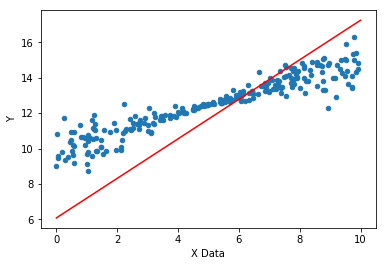

In [37]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(np.linspace(0,10,10),predictions,'r')

# Great Job!